### Preceding Step - import modules (packages)
This step is necessary in order to use external modules (packages). <br>

### <br>Explanation
I've used the following modules:

<ul>
<li>pandas</li>
<li>os</li>
<li>numpy</li>
<li>hebrew_tokenizer</li>
<li>sklearn</li>
</ul>

<br>Please make sure you have hebrew_tokenizer and sklearn modules installed.
<br>If not, you can install them using the next pip commands:

<ul>
<li>For hebrew_tokenizer: pip install hebrew_tokenizer</li>
<li>For sklearn: pip install -U scikit-learn</li>
</ul>

In [ ]:
# imports for reading and writing (input & output) files:
import pandas as pd
import os

In [ ]:
# numpy import 
import numpy as np

# hebrew_tokenizer import
import hebrew_tokenizer as ht

# sklearn import
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.base import TransformerMixin
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

### Reading input files
Reading input files for train annotated corpus (raw text data) corpus and for the test corpus.

### <br>Explanation
Please make sure you have the following excel files in the input folder:
<ul>
<li>annotated_corpus_for_train.xlsx</li>
<li>corpus_for_test.xlsx</li>
</ul>

<br>In addition, I've used the following text files:
<ul>
<li>hebrew_vocabulary_text_file.txt:
    <br>This text file includes different hebrew words that can help identify the gender of the writer.
    <br>i.e. 'חושב', 'חושבת', 'מסתכל', 'מסתכלת' and many more.
    </li><br>
    
<li>stop_word_list_heb_example.txt:
    <br>This text file includes hebrew words that can't identify the gender of the writer.
    <br>Therefore the model will avoid using these words in order to identify the gender of the writer.
    <br>This file was downloaded from the moodle.</li>
</ul>

<br>These text files shall be located in the input folder as well.
<br><br>In conclusion, the input folder shall look like this:
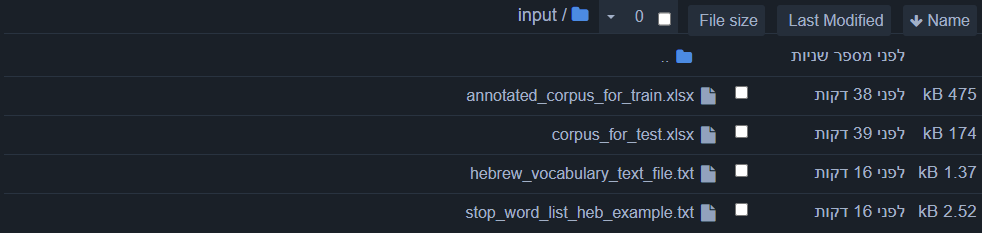

In [ ]:
train_filename = '.' + os.sep + 'input' + os.sep + 'annotated_corpus_for_train.xlsx'
test_filename  = '.' + os.sep + 'input' + os.sep + 'corpus_for_test.xlsx'
df_train = pd.read_excel(train_filename, 'corpus', index_col=None, na_values=['NA'])
df_test  = pd.read_excel(test_filename,  'corpus', index_col=None, na_values=['NA'])

### Defining constants
In this step, I'll define const values, that will be used in the classification model.

### <br>Explanation
The defined const values are:
<ul>
<li>k_HebrewStopWordsFilePath:
    <br>stop_word_list_heb_example file path string</li><br>
    
<li>k_HebrewVocabularyFilePath:
    <br>hebrew_vocabulary_text_file file path string</li><br>
    
<li>k_MaxFeatures:
    <br>Maximal value for the amount of features</li><br>
    
<li>k_MinFeatures:
    <br>Minimal value for the amount of features</li><br>
        
<li>k_NumberOfSplits:
    <br>Amount of groups to split the dataset</li><br>
    
<li>k_NumOfThreads:
    <br>Amount of threads to use while training the model</li>
</ul>

In [ ]:
k_HebrewStopWordsFilePath = '.' + os.sep + 'input' + os.sep + 'stop_word_list_heb_example.txt'
k_HebrewVocabularyFilePath = '.' + os.sep + 'input' + os.sep + 'hebrew_vocabulary_text_file.txt'
k_MaxFeatures = 2000
k_MinFeatures = 1000
k_NumberOfSplits = 5
k_NumOfThreads = 5

### Defining additional class
In this step, I'll define additional class, that will be used in the classification model.

### <br>Explanation
While working on the classification model, i got the next error message:
<br>`TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array`
    
<br>After some research online, I found a solution that suggests creating a new class named 
`DenseTransformer` that inherits from the class `TransformerMixin`.
<br>The new class `DenseTransformer` handles fit and transform methods in a way that won't cause any errors.

<br>After adding the new class `DenseTransformer` to the code, the error disappeared.

In [ ]:
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, y=None, **fit_params):
        return X.todense()

### Defining additional methods
In this step, I'll define additional methods, that will be used in the classification model.

### <br>Explanation
The additional methods are:
<ul>
<li>getTokensListFromStoryFile:
    <br>This method converts story string into hebrew tokens list</li><br>
<li>readWordsFromFile:
    <br>This method reads data from a given file name and returns the content of the file as a list</li><br>
<li>printBestScoreAndParamsValues:
    <br>This method gets a grid search object and prints the best score and the best parameters</li>
</ul>

In [ ]:
def getTokensListFromStoryFile(i_StoryToTokenize):
    hebrewTokens = ht.tokenize(i_StoryToTokenize)
    tokensList = []
    
    for currentToken in hebrewTokens:
        if (currentToken[0] == "HEBREW"):
            tokensList.append(currentToken[1])
    
    return tokensList

In [ ]:
def readWordsFromFile(i_FileName):
    myFile = open(i_FileName, "r", encoding="utf8")
    content = myFile.read()
    wordsList = content.split("\n")
    myFile.close()
    
    return wordsList

In [ ]:
def printBestScoreAndParamsValues(i_GridSearchCVItem):
  bestScore = i_GridSearchCVItem.best_score_
  bestParams = i_GridSearchCVItem.best_params_

  print("best score = {}".format(bestScore))
  print("best params = {}".format(bestParams))

### Defining additional lists
In this step, I'll define additional lists, that will be used in the classification model.

### <br>Explanation
The additional lists are:
<ul>
<li>hebrewVocabularyList:
    <br>This list contains the hebrew vocabulary words from hebrew_vocabulary_text_file.txt file</li><br>
<li>stopWordsList:
    <br>This list contains the hebrew stop words from stop_word_list_heb_example.txt file</li><br>
</ul>

In [ ]:
hebrewVocabularyList = readWordsFromFile(k_HebrewVocabularyFilePath)

In [ ]:
stopWordsList = readWordsFromFile(k_HebrewStopWordsFilePath)

### Defining additional objects
In this step, I'll define additional objects, that will be used in the classification model.

### <br>Explanation
The additional objects are:
<ul>
<li>countVector:
    <br>This object is a CountVectorizer object that gets the following parameters:
        <ul>
        <li>stopWordsList as the stop_words value</li>
        <li>k_MaxFeatures (k_MaxFeatures = 2000) as the max_features value</li>
        <li>getTokensListFromStoryFile method as the tokenizer value</li>
        <li>hebrewVocabularyList as the vocabulary value</li>
        </ul>
    </li><br>
    
<li>pipeLine:
    <br>This object is a Pipeline object that gets the following parameters:
        <ul>
        <li>countVector, that was defined in the first bullet, as the vector value</li>
        <li>a new TfidfTransformer object as the tfidf value</li>
        <li>a new DenseTransformer object as the denseTransformer value</li>
        <li>a new GaussianNB object as the classifier value - <b>additional explanation will follow in training the model sction</b></li>
        </ul>
    </li><br>
    
<li>paramsDict:
    <br>This object is a dictionary that gets the following parameters:
    <ul>
        <li>np.logspace(0,-9, num=100) as the classifier__var_smoothing value</li>
        </ul>
    In addition, many parameters in paramsDict are commented.<br>
    During the work on the assignment, I've used the different parameters and discovered that the best parameter for the model was the classifier__var_smoothing value.<br>
    I've decided to show the commented parameters in order to show the different combinations I've used to get the best results for my classification model.
    </li><br>
    
<li>kFoldObject:
    <br>This object is a KFold object that gets the following parameters:
        <ul>
        <li>k_NumberOfSplits (k_NumberOfSplits = 5) as the n_splits value</li>
        </ul>
    In addition, setting the n_splits value to 5 means that the training dataset will be divided into 5 parts.
    </li><br>
    
<li>gridSearchCV:
    <br>This object is a GridSearchCV object that gets the following parameters:
        <ul>
        <li>pipeLine, that was defined in the second bullet, as the estimator value</li>
        <li>paramsDict, that was defined in the third bullet, as the param_grid value</li>
        <li>kFoldObject, that was defined in the forth bullet, as the cv value</li>
        <li>1 as the verbose value</li>
        <li>f1_weighted as the scoring value</li>
        <li>k_NumOfThreads (k_NumOfThreads = 5) as the n_jobs value</li>
        </ul>
    In addition, the gridSearchCV object contains all the other objects that were defined in the previous bullets.<br>
    Using this object, I can start training the classification model, and later on use it in order to make predications.
    </li>
</ul>

In [ ]:
countVector = CountVectorizer(stop_words = stopWordsList, max_features = k_MaxFeatures, 
                              tokenizer = getTokensListFromStoryFile, vocabulary=hebrewVocabularyList)

In [ ]:
pipeLine = Pipeline([("vector", countVector), ('tfidf', TfidfTransformer()), 
                     ("denseTransformer", DenseTransformer()), ("classifier", GaussianNB())])

In [ ]:
paramsDict = {
    #'vector__max_features': [None, k_MinFeatures, k_MaxFeatures],
    #'vector__max_df': (0, 0.5, 0.75, 1.0),
    #'vector__min_df': (0, 0.5, 0.75, 1.0),
    #'vector__ngram_range': ((1, 1), (1, 2)),
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'classifier__var_smoothing': np.logspace(0,-9, num=100),
}

In [ ]:
kFoldObject = KFold(n_splits = k_NumberOfSplits)

In [ ]:
gridSearchCV = GridSearchCV(estimator=pipeLine, param_grid=paramsDict, cv=kFoldObject, verbose=1,
                           scoring='f1_weighted', n_jobs=k_NumOfThreads)

### Training the model
In this step, I'll train the model using the stories data and the gender labels.<br>
Afer completing the training, the best score and the best parameter will be printed using the `printBestScoreAndParamsValues` method.

<br>
In addidtion, as I wrote in the pipeLine object description at defining additional objects section, I've decided to use naive bayes as the classification model.<br>
<br>Please refer to the next explanation paragraph for the reason I've chosen naive bayes as my classification model.

<br>

### <br>Explanation
Before I started working on this assignment, I've read the text analysis lecture and noticed the next slide:
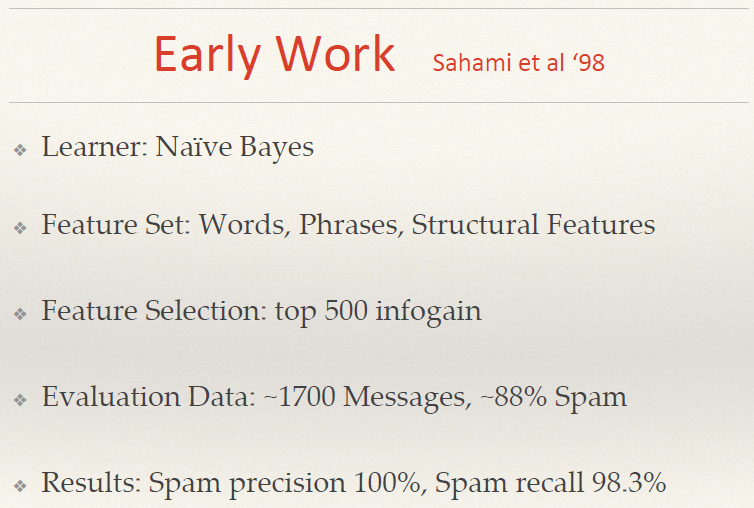

<br>This slide shows how early spam detecting models were developed using naive bayes model.
<br>I've decided to create a similar naive bayes model that will use heberw vocabulary in order to detect the gender of the writer.

In [ ]:
gridSearchCV.fit(df_train.story, df_train.gender)

In [ ]:
printBestScoreAndParamsValues(gridSearchCV)

### Predicting the writer's gender on the test set
In this step, I'll use the trained model to make a gender prediction for each story in the test set.

### <br>Explanation
In order to make a gender prediction, I'll use the gridSearchCV object and store the prediction results in an array called `predictedGenderArr`.

<br>I'll create a copy of the test set and call it `classification_results`.
<br>The prediction array `predictedGenderArr` will be added, to the new data frame `classification_results`, as a new column called `predicted_category`.

<br>In addition, the column `story` will be deleted from the new data frame `classification_results`, since the `story` column is not necessary.

<br>In conclusion, the new data frame `classification_results` shall have the following columns:
<ul>
<li>test_example_id</li>
<li>predicted_category</li>
</ul>

In [ ]:
predictedGenderArr = gridSearchCV.predict(df_test.story)

In [ ]:
classification_results = df_test.copy()

In [ ]:
classification_results["predicted_category"] = predictedGenderArr

In [ ]:
del classification_results['story']

### Save output to csv
After you're done save your output to the 'classification_results.csv' csv file.<br/>
We assume that the dataframe with your results contain the following columns:
* column 1 (left column): 'test_example_id'  - the same id associated to each of the test stories to be predicted.
* column 2 (right column): 'predicted_category' - the predicted gender value for each of the associated story. 

In [ ]:
classification_results.to_csv('classification_results.csv',index=False)